This is the main notebook to design the DnD Dungeon Master

Loading all relevant keys:

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

assert 'OPENAI_API_KEY' in os.environ, "You will need to set an OPENAI_API_KEY"
assert 'LANGCHAIN_API_KEY' in os.environ, "You will need to set an LANGCHAIN_API_KEY"

Importing all relevant libraries:

In [2]:
from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.chains import LLMMathChain
from langchain.prompts import PromptTemplate
from langchain import hub
from langchain.agents import AgentExecutor

import random

Specification from Canvas:

Project Requirements

World Memory: Implement persistent storage of state for each location. The AI must recognize when players revisit a location and present an updated description reflecting prior actions.

Map Generation and Navigation: The AI should create and maintain a coherent map of connected locations, ensuring logical placement and connections.

Dynamic Descriptions and Interactions: Generate unique descriptions and manage NPC or item states dynamically, adapting based on player actions.
Randomized Location Descriptions and Encounters: When players enter a new location, the AI generates a fresh, random description consistent with nearby areas and may spawn new NPCs or items. This allows each exploration to feel novel and immersive while maintaining a coherent world.

Simplified D&D Mechanics: Use a streamlined set of D&D-inspired mechanics (detailed below) to guide the AI’s decisions and narration for combat, exploration, and interactions.

DnD Simplified Mechanics:

NPC Interaction and Combat
NPCs have two attributes: Health Points (HP) and Attack Power.
Combat: When players engage in combat, each side rolls a virtual 1d6 (a six-sided die) and adds it to their Attack Power to determine damage for that turn.

Victory Conditions: The player wins if the NPC’s HP reaches zero, and loses if their own HP does.
Skill Checks and Random Outcomes
When players attempt a risky action (e.g., unlocking a door), the AI rolls a 1d10 (a ten-sided die) for a skill check.
For simple tasks, a roll of 3 or higher succeeds.
For challenging tasks, a roll of 6 or higher is needed.
Descriptions should vary based on success or failure, giving the interaction a creative touch.

Inventory and Simple Item Use
Players can pick up and use basic items like keys or healing potions.
Items: Each item has a single effect—e.g., a potion heals 10 HP, a key unlocks a specific door.
The AI remembers which items have been used or taken to manage inventory without complex tracking.

Experience Points and Leveling (Optional)
Players can gain Experience Points (XP) for completing significant actions or defeating NPCs.
When players reach 50 XP, they "level up," gaining a small HP increase.
This provides a sense of progression with minimal complexity.

In [3]:
@tool
def rolld6() -> int:
    """ Roll a six-sided dice
    """
    rand = random.randint(1, 6)
    return rand

@tool
def rolld10() -> int:
    """ Roll a ten-sided dice
    """
    rand = random.randint(1, 10)
    return rand

@tool
def attack(attacker_power: int, defender_health: int) -> int:
    """ Attacker attacks the defender and check defener health
    args:
        attacker_power: power of the attack from the attacker
        defender_health: health of the defender
    """
    attacker_roll = rolld6({})
    attacker_trueap = attacker_power + attacker_roll
    defender_health -= attacker_trueap

    return defender_health

tools = [rolld6, rolld10, attack]

State Persistence

The AI must track and remember states for each location and NPC to maintain continuity. This includes:

Location State: Track if a door is unlocked, a chest is opened, or an item has been taken.

NPC Status: Remember if NPCs have been defeated, moved, or interacted with.

Inventory: Track items players possess and mark items as “used” once they’re applied (e.g., a used key).

Player Stats: Keep player attributes like HP, XP, and inventory status persistent across moves.


Map Representation

The map is a logical grid or node-based structure, where each “node” represents a unique location.

Location Connections: Each node includes connections to adjacent locations (e.g., north, south, east, west).

Unique Descriptions and Random Encounters: Each time players enter a new node, the AI generates a fresh description that is contextually consistent with nearby areas. The AI may also spawn random NPCs or items, creating an immersive experience while ensuring coherence.

NPC and Item Placement: Each node may contain NPCs or items, which the AI can add or remove based on player actions.

GRADUATE STUDENT:
Graduate students are required to implement additional features to expand the AI’s storytelling capabilities:

Text-to-Speech (TTS): Add a TTS system to narrate the AI-generated descriptions and interactions, enhancing the immersive experience.

Image Generation: Integrate a simple image generation model to create visual representations of locations or key events, adding a visual storytelling element to the text-based game.

In [4]:
llm = ChatOpenAI(temperature = 0, model='gpt-3.5-turbo-1106')

Prompt Template

In [5]:
prompt = hub.pull("hwchase17/openai-functions-agent")
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='

Use AI Agent

In [6]:
# Create an OpenAI Functions agent
agent = create_openai_functions_agent(llm, tools, prompt=prompt)
# Create an agent executor
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent,tools=tools,verbose=True, max_iteration=50, max_execution_time=50)

In [7]:
# Test the agent
question = "Player rolls a d6, and NPC rolls a d6. Who wins?"
response = agent_executor.invoke({"input": question})
print(f"Question: {question}")
print(f"Answer: {response}")



> Entering new AgentExecutor chain...

Invoking: `rolld6` with `{}`


3
Invoking: `rolld6` with `{}`


6The player rolled a 3, and the NPC rolled a 6. The NPC wins this round!

> Finished chain.
Question: Player rolls a d6, and NPC rolls a d6. Who wins?
Answer: {'input': 'Player rolls a d6, and NPC rolls a d6. Who wins?', 'output': 'The player rolled a 3, and the NPC rolled a 6. The NPC wins this round!'}


In [ ]:
scenario = """
    You are a Dungeon Master in a custom DnD game.
    To create a combat scenario, roll and combine results of 2 d10 to get health, and roll a d6 to get attack power. Do this for player and npc separately.
    Before combat starts, you must print out the player and npc stats (health and attack power) in the response.
    In combat, player and npc takes turn attacking each other.
    Remember player and npc health separately.
    You must use the attack tool to simulate attack.
    Print out each individual attack, specifically who's the attacker, and how much health does defender have.
    Combat ends when either player or npc health reaches or below 0.
    After combat ends, announce the winner.
    Outside of combat, whenever players reach a special scenario that requires skill check, the player will be rolling a d10. Roll with the given tool.
    For simple tasks, the player succeeds when they roll 3 or higher.
    For hard tasks, the player succeeds when they roll 7 or higher.
"""

In [9]:

question = "Player has 100 health and 50 attack power. NPC has 200 health and 30 attack power. Player fights NPC. Who wins, and how much health do they have left?"
response = agent_executor.invoke({"input": scenario+question})
print(f"Response: {response['output']}")



> Entering new AgentExecutor chain...

Invoking: `rolld10` with `{}`


7
Invoking: `rolld10` with `{}`


10
Invoking: `rolld6` with `{}`


2
Invoking: `rolld10` with `{}`


9
Invoking: `rolld6` with `{}`


5
Invoking: `attack` with `{'attacker_power': 50, 'defender_health': 200}`


149

C:\Users\longd\AppData\Local\Temp\ipykernel_23272\1164996923.py:22: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  attacker_roll = rolld6({})



Invoking: `attack` with `{'attacker_power': 30, 'defender_health': 100}`


64
Invoking: `attack` with `{'attacker_power': 50, 'defender_health': 170}`


115
Invoking: `attack` with `{'attacker_power': 30, 'defender_health': 100}`


64
Invoking: `attack` with `{'attacker_power': 50, 'defender_health': 140}`


87
Invoking: `attack` with `{'attacker_power': 30, 'defender_health': 100}`


66
Invoking: `attack` with `{'attacker_power': 50, 'defender_health': 110}`


56
Invoking: `attack` with `{'attacker_power': 30, 'defender_health': 100}`


66
Invoking: `attack` with `{'attacker_power': 50, 'defender_health': 80}`


27
Invoking: `attack` with `{'attacker_power': 30, 'defender_health': 100}`


69

> Finished chain.
Response: Agent stopped due to iteration limit or time limit.


In [10]:
question = "Can you write me a combat scenario then execute the combat?"
response = agent_executor.invoke({"input": scenario+question})
print(f"Response: {response['output']}")




> Entering new AgentExecutor chain...

Invoking: `rolld10` with `{}`


3
Invoking: `rolld10` with `{}`


5
Invoking: `rolld6` with `{}`


2
Invoking: `rolld10` with `{}`


3
Invoking: `rolld10` with `{}`


10
Invoking: `rolld6` with `{}`


5
Invoking: `attack` with `{'attacker_power': 2, 'defender_health': 13}`


6
Invoking: `attack` with `{'attacker_power': 3, 'defender_health': 13}`


9
Invoking: `attack` with `{'attacker_power': 2, 'defender_health': 11}`


7
Invoking: `attack` with `{'attacker_power': 3, 'defender_health': 11}`


5
Invoking: `attack` with `{'attacker_power': 2, 'defender_health': 9}`


2
Invoking: `attack` with `{'attacker_power': 3, 'defender_health': 9}`


3
Invoking: `attack` with `{'attacker_power': 2, 'defender_health': 6}`


-2
Invoking: `attack` with `{'attacker_power': 3, 'defender_health': 6}`


-1The combat scenario is as follows:

Player Stats:
- Health: 8
- Attack Power: 2

NPC Stats:
- Health: 13
- Attack Power: 3

Combat Log:
- Player attacks NPC fo

In [11]:
import numpy as np
import random
#Create an empty map
mapsize = 5
grid = np.empty((mapsize, mapsize), dtype=object)
for i in range(mapsize):
    for j in range(mapsize):
        grid[i, j] = {"Description": "Unknown", "NPCs": [], "Items": [], "Doors": [], "Chests": []}
# Define Player Information
player = {"Inventory":[], "Health":100, "XP":0, "Attack_Power":10}
#Select a random starting position
currentLocation = (random.randint(0, mapsize-1), random.randint(0, mapsize-1))

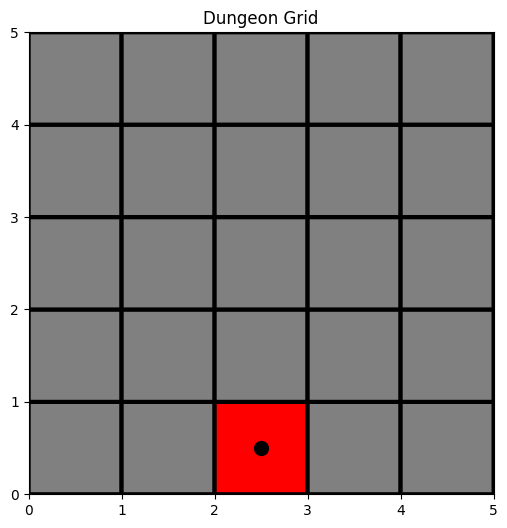

In [12]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
grid[currentLocation]["Description"] = "You are in a dark room."
grid_data = np.zeros((mapsize, mapsize))  # Initialize with 0s (grey)

for i in range(mapsize):
  for j in range(mapsize):
    if grid[i, j]["Description"] != "Unknown":
      grid_data[i, j] = 1  # Set to 1 (red) for known descriptions

cmap = colors.ListedColormap(['gray', 'red']) # Define colormap
plt.figure(figsize=(6, 6))
plt.pcolor(grid_data[::1],cmap=cmap,edgecolors='k', linewidths=3)
plt.title("Dungeon Grid")


# Add a black circle at the current location
plt.scatter(currentLocation[1]+0.5, currentLocation[0]+0.5, s=100, c='black', marker='o')

plt.show()


In [ ]:
context = "TWith the given scenario, you will be designing a DnD campaign from the start."
question = "Can you begin the story?"
response = agent_executor.invoke({"input": scenario+context+question})
print(f"Response: {response['output']}")